# General equations 
$$
        \begin{align}
            \frac{\partial {\bf u}}{\partial t} + \nabla \cdot \Gamma = f
        \end{align} \\
        \begin{align}
            {\bf u} &= \begin{bmatrix}
                p \\
                m \\
                c_f \\
                c_b
            \end{bmatrix}, \,
            \nabla = \frac{\partial}{\partial x}
        \end{align} \\
        \begin{align}
            \Gamma &= \begin{bmatrix}
                        0 & -D_m (1-\beta p) \partial_x m & -D_c \partial_x c_f & 0 
                    \end{bmatrix}^T \\
            f &= \begin{bmatrix}
                 - v \partial_x p - \alpha p c_b \\
                \alpha p c_b \\
                -k_s c_f p + \alpha p c_b \\
                - v \partial_x c_b + k_s c_f p - \alpha p c_b
            \end{bmatrix} \\
        \end{align} \\
        \begin{align}
            v &= \left. a_{br} k_{br} m^2 \right\vert_{x=1}  + \left. a_{gr}k_{gr} m \right\vert_{x=1}
        \end{align}
$$

The following boundaries were taken into account: 

Boundary conditions at $x=0$

$$
\begin{align}
    \frac{\partial p}{\partial x} &= 0 \\
    \frac{\partial c_f}{\partial x} &= 0 \\
    c_{b} &= 0 \\
\end{align}
$$

As for $m$:
$$
\begin{align}
    \sum{J_{total}} &=J_m+J_p=D_m (1-\beta p) \frac{\partial m}{\partial x} - vp=0
\end{align}
$$
Boundary conditions at $x=L$
$$
\begin{align}
    p &= 0 \\
    \frac{\partial m}{\partial x} &= 0 \\
    \frac{\partial c_f}{\partial x} &= 0 \\
    \frac{\partial c_b}{\partial x} &= 0 \\
\end{align}
$$

# Discretization
**Convention**: A subscript of $i$ indicates the spatial discretizetion, an upperscript of $n$ indicates the temporal discretization. A subscript with no upper script means the current timestamp ($n$).

### Equations

$$
\begin {align}
    p_i^{n+1} &= p_i - \frac{\Delta t}{\Delta x} \cdot v (p_{i} - p_{i-1}) - Depoly \\
    m_i^{n+1} &= m_i + D_m \frac{\Delta t}{2 \Delta x^2} \big[(2 - \beta (p_i + p_{i+1}))(m_{i+1}-m_i) - (2 - \beta (p_i + p_{i-1}))(m_{i}-m_{i-1}) \big] + Depoly \\
    c_{f,i}^{n+1} &= c_{f, i} + D_c \frac{\Delta  t}{\Delta x^2} (c_{f, i+1} + c_{f, i-1} - 2 c_{f, i}) - Bind + Depoly \\
    c_{b,i}^{n+1} &= c_{b, i} - v \frac{\Delta  t}{\Delta x} (c_{b, i} - c_{b, i-1}) + Bind - Depoly \\

\end{align}
$$

Where:
$$
\begin{align}
    Depoly &= \Delta t \, \alpha c_{b, i} p_i \\ 
    Bind &= \Delta t \, k_s c_{f, i} p_i \\ 
\end{align}
$$

### Boundaries
#### Right boundary
$$
    p_{M} = 0 \\
    m_{M} = m_{M-2} \\
    c_{f, M} = c_{f, M-2} \\
    c_{b, M} = c_{b, M-2} \\

$$

#### Left boundary
$$
\begin{align}
    p_{0} = p_1 \\
    c_{f, 0} = c_{f, 1} \\
    c_{b, 0} = 0 \\
\end{align}
$$
As for $m$:
$$
\begin{align*}
    \sum{J_{total}} &=J_m+J_p=D_m (1-\beta p) \frac{\partial m}{\partial x} - vp=0 \\
    \Rightarrow  \, & 0 = D_m(1-\beta p_0) \frac{m_1 - m_0}{\Delta x} - p_1 \left( a_{br} k_{br} m^2_1  + a_{gr}k_{gr} m_1 \right) \\
    \Rightarrow \, & m_0 = m_1 - \frac {\Delta x} {D_m (1-\beta p_0)} p_1 m_1 \left( a_{br} k_{br} m_1  + a_{gr}k_{gr} \right) \\ 
\end{align*}
$$



In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# Constants

Dm = 8.4
Dc = 10
beta = 0.1
k_s = 2
k_gr = 8.7
k_br = 2.16E-5
a_gr = 2
a_br = 2


$$
    \begin{align*}
        depoly &= \Delta t \cdot \alpha c_{b,i} p_i \\
        bind &= \Delta t \cdot k_s c_{f,i} p_i
    \end{align*}

$$

$$
    \begin{align*}
        f = \begin{bmatrix}
            v_i \partial_x p - \alpha p c_b \\
            \alpha p c_b \\
            -k_s c_f p + \alpha p c_b \\
            v \partial_x c_b + k_s c_f p - \alpha p c_b
        \end{bmatrix} \\
    \end{align*} \\

$$

In [22]:
def get_f(p, cf, cb, dt, dx, v, alpha):
    """ Calculates the f part of the discretizied equations

    Args:
        p (_type_): p
        cf (_type_): cf
        cb (function): cb
        dt (_type_): dt
        dx (_type_): dx
        v (_type_): v

    Returns:
        tuple: f_p[-1:1], f_m[-1:1], f_cf[-1:1], f_cb[-1:1]
    """
    global k_s

    depoly = (dt*alpha[1: -1])*cb[1:-1]*p[1:-1]
    bind = (dt*k_s)*cf[1:-1]*p[1:-1]
    # print(f"bind={bind}")
    # print(f"Depoly={depoly}")

    f_p = - v*dt/(dx) * (p[1:-1] - p[:-2]) - depoly
    f_m = depoly
    f_cf = depoly - bind
    f_cb = - v*dt/dx * (cb[1: -1] - cb[:-2]) - f_cf
    
    return f_p, f_m, f_cf, f_cb


# get_f(np.random.random(100), np.random.random(100), np.random.random(100), 0.01, 0.1, 5)

In [23]:
def iterate_values(p, m, cf, cb, dt, dx, v, alpha):
    v = m[1] * (a_br*k_br*m[1] + a_gr*k_gr)
    f = get_f(p, cf, cb, dt, dx, v, alpha)
    
    # Calculate boundaries
    p_L, m_L, cf_L, cb_L = 0, m[-2], cf[-2], cb[-2]
    p_0, cf_0, cb_0 = p[1], cf[1], 0
    m_0 = m[1] - (dx/(Dm*(1-beta*p[0]))) * p[1]*m[1] * (a_br*k_br*m[1] + a_gr*k_gr)

    # Calculate inner-points
    m_flux = Dm*dt/(2*dx**2) * \
                ((2-beta*(p[1: -1] + p[2:]))*(m[2:] - m[1: -1]) - (2-beta*(p[1: -1] + p[:-2]))*(m[1: -1] - m[:-2]))
    cf_flux = Dc*dt/(dx**2) * (cf[2:] + cf[:-2] - 2*cf[1:-1])

    # Set boundaries
    p[-1], m[-1], cf[-1], cb[-1] = p_L, m_L, cf_L, cb_L
    p[0], m[0], cf[0], cb[0] = p_0, m_0, cf_0, cb_0

    # Assign new values
    p[1: -1] = p[1: -1] + f[0]
    m[1: -1] = m[1: -1] +  m_flux + f[1]
    cf[1: -1] = cf[1: -1] + cf_flux + f[2]
    cb[1: -1] = cb[1: -1] + f[3]

    return p, m, cf, cb, v

def solver(I, L, T, dx, dt, user_action=None, stability_safety_factor=1.0, alpha_func=0.5, completion_run=False, tolerance=0.01):
    """_summary_
get_f - A function that returns a list of 4 values according to ${\bf f}$. The spatial derivatives would be calculated based on regular finite difference, e.g. $\frac{r_p^{n, m+1} - r_p^{n, m}}{\Delta x}$
    Args:
        I (List[Callable]): Initial condition for all of the dependent variables (list of 4 callables) 
        L (float): Length of domain
        T (float):  Stop time for the simulation 
        dx (float): Space grid unit
        dt (float): Time unit
        user_action (Callable, optional): _description_. Defaults to None.
        stability_safety_factor (float, optional): _description_. Defaults to 1.0.

    Returns:
        _type_: _description_
    """

    global a_br, k_br, a_gr, k_gr, Dm, Dc, beta, l, m_c

    Nt = int(round(T/dt))
    t = np.linspace(0, Nt*dt, Nt+1)      # Mesh points in time

    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)          # Mesh points in space

    p = np.vectorize(I[0], otypes=[float])(x)
    m = np.vectorize(I[1], otypes=[float])(x)
    cf = np.vectorize(I[2], otypes=[float])(x)
    cb = np.vectorize(I[3], otypes=[float])(x)
    alpha = np.vectorize(alpha_func, otypes=[float])(x)
    v = np.zeros(np.size(x))


    for n in t:
        if user_action:
            user_action(p=p, m=m, cf=cf, cb=cb, v=v, dx=dx, dt=dt, x=x, t=t, n=n)

        iterate_values(p, m, cf, cb, dt, dx, v, alpha)


    completed = not completion_run
    while not completed:
        t = np.append(t, t[-1] + dt)
        if user_action:
            user_action(p=p, m=m, cf=cf, cb=cb, v=v, dx=dx, dt=dt, x=x, t=t, n=t[-1])

        p_p, m_p, cf_p, cb_p, v_p = np.copy(p), np.copy(m), np.copy(cf), np.copy(cb), np.copy(v)
        iterate_values(p, m, cf, cb, dt, dx, v, alpha)

        checks = [
            all(np.abs(p - p_p) < tolerance),
            all(np.abs(m - m_p) < tolerance),
            all(np.abs(cf - cf_p) < tolerance),
            all(np.abs(cb - cb_p) < tolerance),
        ]
        completed = all(checks)

    return p, m, cf, cb, x, t


            



In [24]:
import math
from IPython import display
from time import sleep

T = 5
L = 10

I = [
    lambda p: 0.1 * (p < 0.5),
    lambda m: 0.1, # * (1 < m < 1.5),
    lambda cf: 0 * (2 < cf < 4),
    lambda cb: 0.05 * (0 < cb < 0.5),
]

# fig = plt.figure()
v = np.array(0)
def append_v(**kwargs):
    global v
    v_timestamp = kwargs['v']
    v = np.append(v, v_timestamp)

def plot_live(**kwargs):
    n = kwargs['n']
    if not( n % 0.01 <= 1e-6):
        return
        
    x = kwargs['x']
    p = kwargs['p']
    m = kwargs['m']
    cf = kwargs['cf']
    cb = kwargs['cb']

    fig = plt.figure(figsize=(8, 6))

    plt.plot(x, m, '-r', label="Monomer")
    plt.plot(x, p, 'black', label="Polymer")
    plt.plot(x, cf, 'g', label="Cofilin free")
    plt.plot(x, cb, 'b', label="Cofilin bound")

    plt.title(f"t={n}")
    plt.xlabel("x")
    plt.ylim((-0.1, 1))
    plt.grid()
    plt.legend()

    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(0.1)
    plt.clf()
    plt.close(fig)

def log_numbers(**kwargs):
    parameters = ["p", "m", "cf", "cb", "n"]
    [print(f"{k}: {kwargs[k]}, ", end="") for k in parameters]
    print()

def aggregate_gen(arr):
    def aggregate(**kwargs):
        for k in arr:
            _sum = sum(kwargs[k])
            print(f"{k}: {_sum}")
            

    return aggregate


monomers = []
cofilin = []

def mass_sum(**kwargs):
    global L, monomers

    x = kwargs["x"]
    p = kwargs["p"]
    m = kwargs["m"]
    cb = kwargs["cb"]
    cf = kwargs["cf"]

    sum_p = sum(p)/len(x)
    sum_m = sum(m)/len(x)
    sum_cb = sum(cb)/len(x)
    sum_cf = sum(cf)/len(x)
    monomers.append(sum_m + sum_p)
    cofilin.append(sum_cb + sum_cf)
    return 


    
sol = solver(I, L, T, 0.1, 1e-5, user_action=mass_sum, alpha_func=lambda y: 10*math.tanh(0.5*y), completion_run=False, tolerance=1e-6)


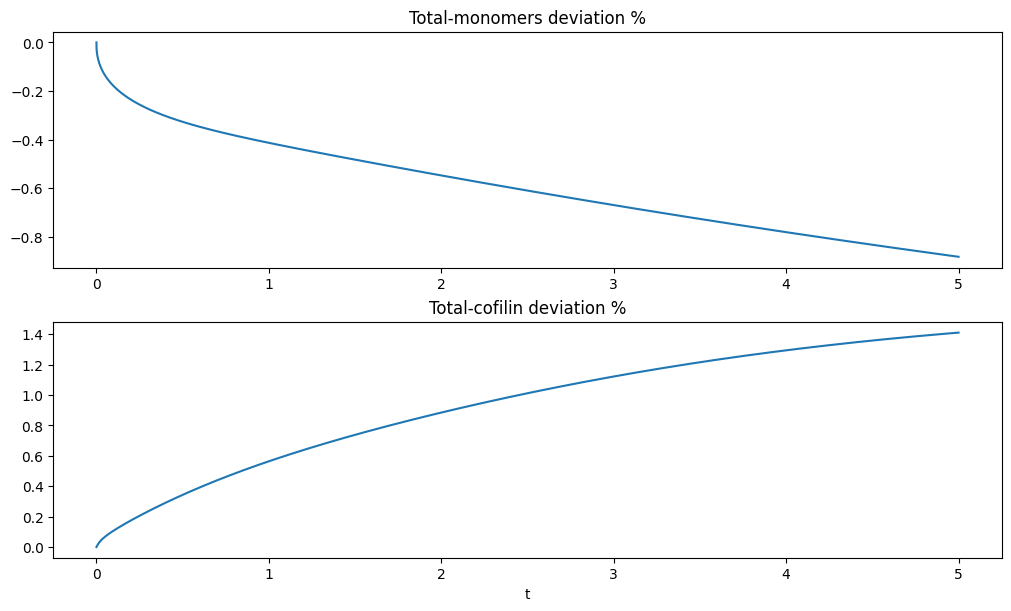

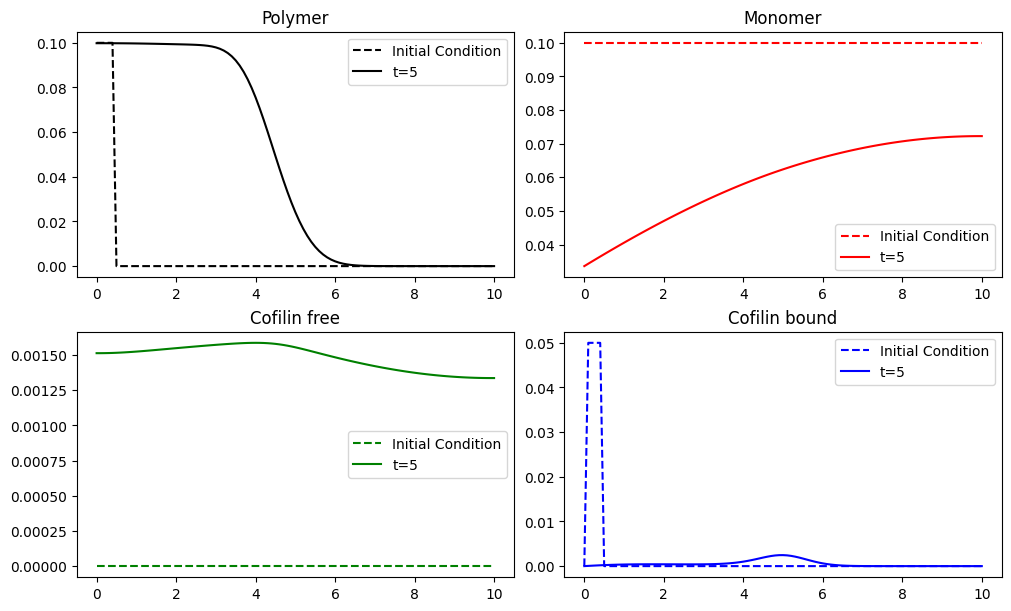

In [25]:
def plot_solution(I, T, p, m, cf, cb, x, t, size=(10, 6), completion_run=False, plot_initial=True):
    fig, axes = plt.subplots(2, 2, figsize=size, layout='constrained')
    titles = [
        "Polymer",
        "Monomer",
        "Cofilin free",
        "Cofilin bound",
    ]
    solutions = {
        "p": p,
        "m": m,
        "cf": cf,
        "cb": cb,
    }
    styles = {
        "p": "black",
        "m": "red",
        "cf": "green",
        "cb": "blue",
    }

    solution_label = f"t={T} (Final)" if completion_run else f"t={T}"
    for ax, title, y, init in zip(axes.flat, titles, solutions.keys(), I):
        initial_condition = np.vectorize(init, otypes=[float])(x)
        
        ax.set_title(title)
        ax.plot(x, initial_condition, styles[y], ls="--", label="Initial Condition")
        ax.plot(x, solutions[y], styles[y], label=solution_label)
        ax.legend()
        
def plot_errors(monomers, cofilin, t, size=(10, 6)):
    monomers_error = 100*(monomers - monomers[0])/monomers[0]
    cofilin_error = 100*(cofilin - cofilin[0])/cofilin[0]

    fig, axes = plt.subplots(2, 1, figsize=size, layout='constrained')

    axes[0].plot(t, monomers_error)
    axes[0].set_title("Total-monomers deviation %")
    
    axes[1].plot(t, cofilin_error)
    axes[1].set_title("Total-cofilin deviation %")
    axes[1].set_xlabel("t")


plot_errors(monomers, cofilin, sol[-1])
plot_solution(I, T, *sol, completion_run=False)